In [1]:
#auto load changes 
%load_ext autoreload
%autoreload 2

#line profiler
%load_ext line_profiler

In [2]:
import sys
# import pyccl as ccl#
import pickle
#import camb
from classy import Class
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.insert(0,'/home/tkarim/SkyLens/') #path to skylens
sys.path.insert(0,'/home/tkarim/SkyLens/skylens/') #path to skylens
# from importlib import reload

from skylens import *
from survey_utils import *

#only for python3
import importlib
reload=importlib.reload

from time import time

In [3]:
#setting up virtual dask cluster for calculations. Adjust memory and threads according to your system.
from distributed import LocalCluster
from dask.distributed import Client 
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
c=LocalCluster(n_workers=1,processes=False,memory_limit='150gb',threads_per_worker=4,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(c)

In [4]:
#Import wigner files

wigner_files={} #FIXME: run Gen_wig_m0.py to generate these files and then pass their path here. These are large files, make sure they are not included in git.
# In file names l3500 refers to ell_max for which wigner function was calculated. It should be same or larger than ell_max in your measurements. 
# |w2100 is the max ell for window. This should be atleast 2 X ell_max in the measurements.
wigner_files[0]= '../temp/dask_wig3j_l2048_w4096_0_reorder.zarr/'

# wigner_files[2]= '/Users/Deep/dask_temp/dask_wig3j_l3500_w2100_2_reorder.zarr' #everything is spin 0, should not require this. if needed, compute using Gen_wig_m2.py

# Power Spectrum covariance

First we define the cosmology

In [5]:
#set cosmology
cosmo_params = {'h': 0.6736,
 'Omb': 0.04930,
 'Omd': 0.26447,
 'Om': 0.3151898,
 'Ase9': 2.083,
 'mnu': 0.06,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.9649,
 'alpha_s': 0.0,
 'N_ur': 2.0328,
 'N_ncdm': 1.0,
 'omega_ncdm': 0.0014198,
 'w': -1.0,
 'wa': 0.0,
 'Oml': 0.68623, #set manually
 'z_max': 2.45,
 'OmR': 0.}

If `test` is set to `True` then we only run it for a crude approximation.

In [6]:
test = False

if test:
    NSIDE = 256
    lmax_cl = 3 * NSIDE
    binsize = 10
else:
    NSIDE = 1024
    lmax_cl = 2 * NSIDE
    binsize = 100

Set up relevant parameters to run Skylens

In [7]:
#setup parameters
#FIXME: Check all the values below.
#lmax_cl=1024 #min and max for ell
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

#following defines the ell bins. Using log bins in example, feel free to change.
lmin_cl_Bins=100
lmax_cl_Bins=lmax_cl-10
Nl_bins=20
#l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
l_bins = np.arange(lmin_cl, lmax_cl, binsize)
#lb=np.sqrt(l_bins[1:]*l_bins[:-1])
lb=0.5*(l_bins[1:]+l_bins[:-1])

l=l0
# l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if computation is too heavy and we want to use fewer ell

do_cov=True # if you want to get covariance. Covariance is slow and this should be false if you are calling skylens inside mcmc.
bin_cl=True #bin the theory and covaraince. 

use_window=True #if you want to include the window effect. Code will return pseudo-cl and pseudo-cl covariance
store_win=True # to store window, for some internal reasons. leave it to true.
window_lmax=2*lmax_cl #smaller value for testing. This should be 2X ell_max in the measurements.

use_binned_l=False  #FIXME: to speed up computation if using pseudo-cl inside mcmc. Needs to be tested. Leave it false for now.

SSV_cov=False # we donot have good model for super sample and tri-spectrum. We can chat about implementing some approximate analytical forms.
tidal_SSV_cov=False
Tri_cov=False 

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

In [8]:
def cmb_bins_here(zs=1090,l=None,use_window=use_window,unit_win=False,nside=1024,zmax=2.45):
    """
    unit_win = boolean mask 
    nside = 2048; same as sims
    This function prepares the cmb lensing data into format required for input into skylens for theory predictions.
    """
    ztomo_bins_dict={}
    ztomo_bins_dict[0]={}

    ztomo_bins_dict=zbin_pz_norm(ztomo_bins_dict=ztomo_bins_dict,
                                 tomo_bin_indx=0,zbin_centre=np.atleast_1d(zs),
                                 p_zspec=np.atleast_1d(1),
                   ns=0,bg1=1)
    ztomo_bins_dict['n_bins']=1 #easy to remember the counts
    ztomo_bins_dict['zmax']=np.atleast_1d([zmax])
    #ztomo_bins_dict['zp_sigma']=0
    #ztomo_bins_dict['zp_bias']=0
    ztomo_bins_dict['nz']=1

    SN_read=np.genfromtxt('/mnt/store1/tkarim/cmb_lensing/data/MV/nlkk.dat',
                          names=('l','nl','nl2'))  #shot noise
    SN_intp=interp1d(SN_read['l'],SN_read['nl'],bounds_error=False, fill_value=0)      #FIXME: make sure using the correct noise power spectra.
    SN=SN_intp(l)
    SN *= 0 #DON'T DO THIS WHEN USING REAL DATA
#     SN=np.ones_like(l)
    ztomo_bins_dict['SN']={}
    ztomo_bins_dict['SN']['kappa']=SN.reshape(len(SN),1,1)
    if use_window:
        ztomo_bins_dict=set_window_here(ztomo_bins_dict=ztomo_bins_dict,
                                   nside=nside, cmb=True)
    return ztomo_bins_dict

In [9]:
def set_window_here(ztomo_bins_dict={}, nside=1024, mask = None, unit_win=False, cmb=False):
    """
        This function sets the window functions for the datasets. 
        These windows are necessary for converting cl to pseudo-cl.
    """
    #FIXME: make sure nside, etc. are properly matched. if possible, use same nside for cmb and galaxy maps. Use ud_grade where necessary.
    for i in np.arange(ztomo_bins_dict['n_bins']):
        if unit_win:
            cl_map=hp.ma(np.ones(12*nside*nside))
            cl_i=1
        elif cmb:
            #cl_map=np.load('/mnt/store1/tkarim/mask_2048.fits') #FIXME: add the CMB lensing window here.
            #window_map=np.load("/mnt/store1/boryanah/AbacusSummit_base_c000_ph006/light_cones/mask_edges_ring_2048.npy")
            window_map=np.load("/mnt/store1/tkarim/cmb_lensing/data/dr8/elg_ran1024.npy")
            window_map = window_map.astype(np.float64)
            window_map_noise = window_map
            #mask = cl_map
        else:
            window_map=np.load('/mnt/store1/tkarim/cmb_lensing/data/dr8/elg_ran1024.npy') #randoms are the window function.
            #window_map=np.load("/mnt/store1/boryanah/AbacusSummit_base_c000_ph006/light_cones/mask_edges_ring_2048.npy") #randoms are the window function.
            window_map = window_map.astype(np.float64)
            window_map_noise = np.sqrt(window_map)
        
        if mask is None:
            mask=window_map>0 #FIXME: input proper mask if possible
        window_map[window_map<0]=0 #numerical issues can make this happen
        window_map/=window_map[mask].mean() #normalize window to 1
        window_map[~mask]=hp.UNSEEN
        #print(window_map_noise[1:100])
        window_map_noise[~mask]=hp.UNSEEN
        #print(window_map_noise[~mask])
        #print(window_map[~mask])
        #indow_map=hp.ma(window_map)
        #indow_map_noise = hp.ma(np.copy(noise_map))
        #indow_map.mask=~mask
        #indow_map_noise.mask=~mask
        
        ztomo_bins_dict[i]['window']=window_map
        ztomo_bins_dict[i]['window_N']=window_map_noise #window of noise 

    return ztomo_bins_dict

In [10]:
def zbin_pz_norm(ztomo_bins_dict={},tomo_bin_indx=None,zbin_centre=None,p_zspec=None,ns=0,bg1=1,
                 mag_fact=0,k_max=0.3):
    """
        This function does few pre-calculations and sets some parameters for datasets that 
        will be input into skylens.
    """

    dzspec=np.gradient(zbin_centre) if len(zbin_centre)>1 else 1 #spec bin width

    if np.sum(p_zspec*dzspec)!=0:
        p_zspec=p_zspec/np.sum(p_zspec*dzspec) #normalize histogram
    else:
        p_zspec*=0
    nz=dzspec*p_zspec*ns

    i=tomo_bin_indx
    x= p_zspec>-1 #1.e-10; incase we have absurd p(z) values

    ztomo_bins_dict[i]['z']=zbin_centre[x]
    ztomo_bins_dict[i]['dz']=np.gradient(zbin_centre[x]) if len(zbin_centre[x])>1 else 1
    ztomo_bins_dict[i]['nz']=nz[x]
    ztomo_bins_dict[i]['ns']=ns
    ztomo_bins_dict[i]['W']=1. #redshift dependent weight
    ztomo_bins_dict[i]['pz']=p_zspec[x]*ztomo_bins_dict[i]['W']
    ztomo_bins_dict[i]['pzdz']=ztomo_bins_dict[i]['pz']*ztomo_bins_dict[i]['dz']
    ztomo_bins_dict[i]['Norm']=np.sum(ztomo_bins_dict[i]['pzdz'])
    ztomo_bins_dict[i]['b1']=bg1 # FIXME: this is the linear galaxy bias. Input proper values. We can also talk about adding other bias models if needed.
    ztomo_bins_dict[i]['bz1'] = None #array; set b1 to None if passing redz dependent bias 
    ztomo_bins_dict[i]['AI']=0. # this will be zero for our project
    ztomo_bins_dict[i]['AI_z']=0. # this will be zero for our project
    ztomo_bins_dict[i]['mag_fact']=mag_fact  #FIXME: You need to figure out the magnification bias prefactor. For example, see appendix B of https://arxiv.org/pdf/1803.08915.pdf
    ztomo_bins_dict[i]['shear_m_bias'] = 1.  #
    
    #convert k to ell
    zm=np.sum(ztomo_bins_dict[i]['z']*ztomo_bins_dict[i]['pzdz'])/ztomo_bins_dict[i]['Norm']
    ztomo_bins_dict[i]['lm']=k_max*cosmo_h.comoving_transverse_distance(zm).value 
    return ztomo_bins_dict

In [19]:
def source_tomo_bins(zphoto_bin_centre=None,p_zphoto=None,ntomo_bins=None,ns=26,
                     zspec_bin_centre=None,n_zspec=100,ztomo_bins=None,
                     f_sky=0.3,nside=256,use_window=False,
                    bg1=1,l=None,mag_fact=0,
                    k_max=0.3,use_shot_noise=True,**kwargs):
    """
        Setting galaxy redshift bins in the format used in skylens code.
        Need
        zbin_centre (array): redshift bins for every source bin. if z_bins is none, then dictionary with
                    with values for each bin
        p_zs: redshift distribution. same format as zbin_centre
        z_bins: if zbin_centre and p_zs are for whole survey, then bins to divide the sample. If
                tomography is based on lens redshift, then this arrays contains those redshifts.
        n_gal: number density for shot noise calculation
        n_zspec : number of histogram bins in spectroscopic dndz (if zspec_bin_centre is not passed)
        ztomo_bins : edges of tomographic bins in photometric redshift (assign galaxies to tomo bins using photz)
                    e.g. [0.6, 1., 1.6]
        k_max : cut in k-space; CHECK FOR BUG
    """
    ztomo_bins_dict={} #dictionary of tomographic bins

    if ntomo_bins is None:
        ntomo_bins=1

    if ztomo_bins is None:
        ztomo_bins=np.linspace(min(zphoto_bin_centre)-0.0001,max(zphoto_bin_centre)+0.0001,ntomo_bins+1)
    if zspec_bin_centre is None: #histogram of dndz; defines bin centres
        zspec_bin_centre=np.linspace(0,max(ztomo_bins)+1,n_zspec)
    dzspec=np.gradient(zspec_bin_centre)
    dzphoto=np.gradient(zphoto_bin_centre) if len(zphoto_bin_centre)>1 else [1]
    zphoto_bin_centre=np.array(zphoto_bin_centre)

    #zl_kernel=np.linspace(0,max(zbin_centre),50) #galaxy position kernel; identical to b*dndz
    #lu=Tracer_utils() 
    #cosmo_h=cosmo_h_PL #cosmology parameters in astropy convention; default is Skylens default

    zmax=max(ztomo_bins)

    l=[1] if l is None else l
    ztomo_bins_dict['SN']={} #shot noise dict
    ztomo_bins_dict['SN']['galaxy']=np.zeros((len(l),ntomo_bins,ntomo_bins)) # ell X no. of tomo bins X no. of tomo bins 
    ztomo_bins_dict['SN']['kappa']=np.zeros((len(l),ntomo_bins,ntomo_bins))

    for i in np.arange(ntomo_bins):
        ztomo_bins_dict[i]={}
        indx=zphoto_bin_centre.searchsorted(ztomo_bins[i:i+2]) #find bins that belong to this photometric bin

        if indx[0]==indx[1]: #if only one bin
            indx[1]=-1
        zbin_centre=zphoto_bin_centre[indx[0]:indx[1]]
        p_zspec=p_zphoto[indx[0]:indx[1]] #assuming spectroscopic and photometric dndz are same; CHANGE IF NOT 
        nz=ns*p_zspec*dzphoto[indx[0]:indx[1]]
        ns_i=nz.sum()

        ztomo_bins_dict = zbin_pz_norm(ztomo_bins_dict=ztomo_bins_dict, tomo_bin_indx=i, 
                                       zbin_centre=zbin_centre,
                                       p_zspec=p_zspec,ns=ns_i,bg1=bg1, mag_fact=mag_fact,k_max=k_max)
        
        zmax=max([zmax,max(ztomo_bins_dict[i]['z'])])
        if use_shot_noise:
            ztomo_bins_dict['SN']['galaxy'][:,i,i]=galaxy_shot_noise_calc(zg1=ztomo_bins_dict[i],
                                                                  zg2=ztomo_bins_dict[i])
            #the following is set in the CMB lensing bin
            #zs_bins['SN']['kappa'][:,i,i]=shear_shape_noise_calc(zs1=zs_bins[i],zs2=zs_bins[i],
            #                                                     sigma_gamma=sigma_gamma) #FIXME: This is almost certainly not correct

    ztomo_bins_dict['n_bins']=ntomo_bins #easy to remember the counts
    #ztomo_bins_dict['z_lens_kernel']=zl_kernel
    ztomo_bins_dict['zmax']=zmax
    ztomo_bins_dict['zp']=zphoto_bin_centre
    ztomo_bins_dict['pz']=p_zphoto
    ztomo_bins_dict['z_bins']=ztomo_bins
    
    if use_window:
        ztomo_bins_dict=set_window_here(ztomo_bins_dict=ztomo_bins_dict,nside=nside, unit_win=False)
    return ztomo_bins_dict

In [20]:
def DESI_elg_bins(ntomo_bins=1, f_sky=0.3,nside=256,use_window=use_window, bg1=1, 
                       l=None, mag_fact=0,ztomo_bins=None,**kwargs):

    home='../../'
    fname='nz_blanc+abacus.txt'
#     t=np.genfromtxt(home+fname,names=True,skip_header=3)
    #t=np.genfromtxt(home+fname,names=True)
    t = pd.read_csv(home + fname)
    dz=t['Redshift_mid'][2]-t['Redshift_mid'][1]
    zmax=max(t['Redshift_mid'])+dz/2
    zmin=min(t['Redshift_mid'])-dz/2

    z=t['Redshift_mid']
    
    pz=t['dndz/deg^2']
    
    ns=np.sum(pz)
    d2r = 180/np.pi
    ns/=d2r**2 #convert from deg**2 to rd**2

    if ztomo_bins is None: #this defines the bin edges if splitting the sample into bins. Preferably pass it as an argument whenusing multiple bins.
        ztomo_bins=np.linspace(zmin, min(2,zmax), ntomo_bins+1) #define based on experiment
    print(zmin,zmax,ztomo_bins,ns)
    return source_tomo_bins(zphoto_bin_centre=z, p_zphoto=pz, ns=ns, ntomo_bins = ntomo_bins,
                            mag_fact=mag_fact, ztomo_bins=ztomo_bins,f_sky=f_sky,nside=nside,
                            use_window=use_window,bg1=bg1, l=l,**kwargs)

In [21]:
def SkyLens_cls(nside, bg1, fsky, zmin = 0.1, zmax = 2.45104189964307, nowin = False, Win = None):
    """Returns Skylens Cls based on given maps.
    
    Inputs:
        nside (int) : nside for healpy
        bg1 (float) : linear bias term for galaxies
        fsky (float) : fsky of the map to be used 
        zmin (float) : min redshift for CMB lensing kernel
        zmax (float) : max redshift for CMB lensing kernel
        nowin (bool) : whether to calculate Cls without window
        Win (dict) : optional dict; pass saved window calculated before
        
    Returns:
        results (dict) : Skylens dict containing Cls, pCls, coupling matrices
    """
    
    results = {}
    
    #tomographed redshift bins for the galaxies
    #zl_bin=DESI_elg_bins(l=l, f_sky = fsky, nside = NSIDE, bg1 = bg1) #originally l = None
    zl_bin=DESI_elg_bins(l=l, f_sky = fsky, nside = NSIDE, bg1 = bg1)
    
    #redshift bins for cmb
    zs_bin=cmb_bins_here(l=l, nside = NSIDE, zmax = zmax)# lensing source bin
    
    #names of maps
    corr_kk=('kappa','kappa')
    corr_gg=('galaxy','galaxy')
    corr_gk=('galaxy','kappa')
    corrs=[corr_kk, corr_gg, corr_gk]
    
    z_PS=np.linspace(zmin, zmax, 100) #redshifts where P(k) will be evaluated
    
    if Win is not None:
        kappa0=Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=fsky,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=z_PS)
        
    else:
        kappa0=Skylens(kappa_zbins=zs_bin,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, galaxy_zbins=zl_bin,
                                       use_window=use_window,Tri_cov=Tri_cov, #Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=fsky,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=z_PS)
    results['kappa0'] = kappa0
    
    if(nowin):
        kappa0_nowin=Skylens(kappa_zbins=zs_bin,do_cov=False,bin_cl=False,l_bins=None,l=l0_nowin, 
                     galaxy_zbins=zl_bin,
                                       use_window=False,Tri_cov=Tri_cov, #Win = Win,
                                       use_binned_l=use_binned_l,wigner_files=wigner_files,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=fsky,
                                       store_win=store_win,window_lmax=window_lmax,
                                       corrs=corrs, scheduler_info=client.scheduler_info(), log_z_PS=1,
                                       cosmo_params = cosmo_params, z_PS=z_PS)
        results['kappa0_nowin'] = kappa0_nowin
    
    return results

## Run Skylens to get relevant $C_l$s and coupling matrices

In [22]:
client

Client Scheduler: inproc://10.0.0.147/28240/1 Dashboard: http://10.0.0.147:8787/status,Cluster Workers: 1 Cores: 4 Memory: 150.00 GB


We calculate $f_{sky}$ by using the relevant AbacusSummit mask

In [23]:
mask = np.load("/mnt/store1/tkarim/cmb_lensing/data/dr8/elg_ran1024.npy")
fsky = np.sum(mask)/mask.size

In [24]:
bg1 = 1.75
zlow = 0.1
zhigh = 2.45104189964307

In [8]:
#if saved window previously, can load it and pass it
win = pickle.load( open( "../../desi-lensing-cc/dat/Abacus_Win_ncdm.p", "rb" ) )

In [25]:
%time results = SkyLens_cls(nside = NSIDE, bg1 = bg1, fsky = fsky, zmin = zlow, zmax = zhigh, nowin = False)

0.41250000000000003 1.4374999999999996 [0.4125 1.4375] 4.570437260729055
Tracer utils has tracers:  ['galaxy', 'kappa']


/home/tkarim/SkyLens/skylens/angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017


pk_params dict was none, intialized with default
cosmology interpolation range 0.0 2.455
power spectra class_pk
Win gen: step size 4 2048 4097.0 1
wigner_files: {0: '../temp/dask_wig3j_l2048_w4096_0_reorder.zarr/'}
wigner done dict_keys([])
set window_cl: cl0,cl_b done 9.846687316894531e-05
set window_cl: cl done 0.002335071563720703 302.415 0.0
Win_cli ('kappa', 'kappa', 0, 0) ('kappa', 'kappa') (0, 0)
Win_cli ('galaxy', 'galaxy', 0, 0) ('galaxy', 'galaxy') (0, 0)
Win_cli ('galaxy', 'kappa', 0, 0) ('galaxy', 'kappa') (0, 0)
set window_cl: cl done 0.5556545257568359 302.415 0.0
cl+cov bags done 3 6 1.0686721801757812
set_window_cl done 253.28824424743652
setting windows, coupling matrices  <Client: 'inproc://10.0.0.147/28240/1' processes=1 threads=4, memory=150.00 GB>
doing lm 0
done lm cl+cov graph 0 0.0006778240203857422 503.739 inproc://10.0.0.147/28240/3
done lm 0 0.6212124824523926
doing lm 4
done lm cl+cov graph 4 0.0011265277862548828 503.739 inproc://10.0.0.147/28240/3
done lm 

done lm cl+cov graph 196 0.0007045269012451172 503.724 inproc://10.0.0.147/28240/3
got wig3j 196 268.501 (306, 11) 3
got wig3j 192 268.501 (306, 11) 3
got wig3j 188 268.501 (306, 11) 3
got wig3j 160 268.501 (306, 11) 3
got wig3j 184 268.501 (306, 11) 3
got wig3j 180 268.501 (306, 11) 3
got wig3j 176 268.501 (306, 11) 3
got wig3j 172 268.501 (306, 11) 3
got wig3j 168 268.501 (306, 11) 3
got wig3j 164 268.501 (306, 11) 3
done lm 196 36.00486373901367
doing lm 200
done lm cl+cov graph 200 0.001348257064819336 503.721 inproc://10.0.0.147/28240/3
done lm 200 0.6152329444885254
doing lm 204
done lm cl+cov graph 204 0.0010416507720947266 503.721 inproc://10.0.0.147/28240/3
done lm 204 0.586392879486084
doing lm 208
done lm cl+cov graph 208 0.0010409355163574219 503.721 inproc://10.0.0.147/28240/3
done lm 208 0.5860536098480225
doing lm 212
done lm cl+cov graph 212 0.0007610321044921875 503.721 inproc://10.0.0.147/28240/3
done lm 212 0.5855073928833008
doing lm 216
done lm cl+cov graph 216 0.0

got wig3j 380 268.501 (306, 11) 3
got wig3j 384 268.501 (306, 11) 3
got wig3j 376 268.501 (306, 11) 3
got wig3j 372 268.501 (306, 11) 3
got wig3j 364 268.501 (306, 11) 3
got wig3j 368 268.501 (306, 11) 3
done lm 396 33.824469327926636
doing lm 400
done lm cl+cov graph 400 0.0012211799621582031 503.702 inproc://10.0.0.147/28240/3
done lm 400 0.5854055881500244
doing lm 404
done lm cl+cov graph 404 0.0009570121765136719 503.702 inproc://10.0.0.147/28240/3
done lm 404 0.5758354663848877
doing lm 408
done lm cl+cov graph 408 0.0006630420684814453 503.702 inproc://10.0.0.147/28240/3
done lm 408 0.5790221691131592
doing lm 412
done lm cl+cov graph 412 0.0007939338684082031 503.702 inproc://10.0.0.147/28240/3
done lm 412 0.5778906345367432
doing lm 416
done lm cl+cov graph 416 0.0009500980377197266 503.702 inproc://10.0.0.147/28240/3
done lm 416 0.5815346240997314
doing lm 420
done lm cl+cov graph 420 0.0009622573852539062 503.702 inproc://10.0.0.147/28240/3
done lm 420 0.5821776390075684
doi

got wig3j 564 268.501 (306, 11) 3
done lm 596 35.7027952671051
doing lm 600
done lm cl+cov graph 600 0.0008754730224609375 503.683 inproc://10.0.0.147/28240/3
done lm 600 0.5881545543670654
doing lm 604
done lm cl+cov graph 604 0.0006873607635498047 503.683 inproc://10.0.0.147/28240/3
done lm 604 0.5821418762207031
doing lm 608
done lm cl+cov graph 608 0.0006709098815917969 503.683 inproc://10.0.0.147/28240/3
done lm 608 0.5807645320892334
doing lm 612
done lm cl+cov graph 612 0.0006420612335205078 503.683 inproc://10.0.0.147/28240/3
done lm 612 0.5848884582519531
doing lm 616
done lm cl+cov graph 616 0.0006394386291503906 503.683 inproc://10.0.0.147/28240/3
done lm 616 0.5848405361175537
doing lm 620
done lm cl+cov graph 620 0.0006175041198730469 503.683 inproc://10.0.0.147/28240/3
done lm 620 0.5800800323486328
doing lm 624
done lm cl+cov graph 624 0.0013763904571533203 503.683 inproc://10.0.0.147/28240/3
done lm 624 0.5831146240234375
doing lm 628
done lm cl+cov graph 628 0.00113201

done lm cl+cov graph 804 0.00101470947265625 503.664 inproc://10.0.0.147/28240/3
done lm 804 0.584965705871582
doing lm 808
done lm cl+cov graph 808 0.0010786056518554688 503.664 inproc://10.0.0.147/28240/3
done lm 808 0.5839805603027344
doing lm 812
done lm cl+cov graph 812 0.0006399154663085938 503.664 inproc://10.0.0.147/28240/3
done lm 812 0.5821964740753174
doing lm 816
done lm cl+cov graph 816 0.0009553432464599609 503.664 inproc://10.0.0.147/28240/3
done lm 816 0.5821516513824463
doing lm 820
done lm cl+cov graph 820 0.0011696815490722656 503.664 inproc://10.0.0.147/28240/3
done lm 820 0.583388090133667
doing lm 824
done lm cl+cov graph 824 0.000843048095703125 503.664 inproc://10.0.0.147/28240/3
done lm 824 0.5823755264282227
doing lm 828
done lm cl+cov graph 828 0.001001596450805664 503.664 inproc://10.0.0.147/28240/3
done lm 828 0.5855343341827393
doing lm 832
done lm cl+cov graph 832 0.0010488033294677734 503.664 inproc://10.0.0.147/28240/3
done lm 832 0.5860223770141602
doi

done lm cl+cov graph 1016 0.0009143352508544922 503.646 inproc://10.0.0.147/28240/3
done lm 1016 0.5768845081329346
doing lm 1020
done lm cl+cov graph 1020 0.0010142326354980469 503.646 inproc://10.0.0.147/28240/3
done lm 1020 0.5803117752075195
doing lm 1024
done lm cl+cov graph 1024 0.0009703636169433594 503.646 inproc://10.0.0.147/28240/3
done lm 1024 0.5753886699676514
doing lm 1028
done lm cl+cov graph 1028 0.0010750293731689453 503.646 inproc://10.0.0.147/28240/3
done lm 1028 0.5765671730041504
doing lm 1032
done lm cl+cov graph 1032 0.0006756782531738281 503.646 inproc://10.0.0.147/28240/3
done lm 1032 0.5764122009277344
doing lm 1036
done lm cl+cov graph 1036 0.0016720294952392578 503.646 inproc://10.0.0.147/28240/3
got wig3j 1000 268.501 (306, 11) 3
got wig3j 1036 268.501 (306, 11) 3
got wig3j 1032 268.501 (306, 11) 3
got wig3j 1028 268.501 (306, 11) 3
got wig3j 1024 268.501 (306, 11) 3
got wig3j 1020 268.501 (306, 11) 3
got wig3j 1016 268.501 (306, 11) 3
got wig3j 1012 268.50

done lm cl+cov graph 1216 0.0010008811950683594 503.627 inproc://10.0.0.147/28240/3
done lm 1216 0.5761275291442871
doing lm 1220
done lm cl+cov graph 1220 0.0012035369873046875 503.627 inproc://10.0.0.147/28240/3
done lm 1220 0.5766501426696777
doing lm 1224
done lm cl+cov graph 1224 0.0010211467742919922 503.627 inproc://10.0.0.147/28240/3
done lm 1224 0.5780482292175293
doing lm 1228
done lm cl+cov graph 1228 0.00058746337890625 503.627 inproc://10.0.0.147/28240/3
done lm 1228 0.5764544010162354
doing lm 1232
done lm cl+cov graph 1232 0.0011625289916992188 503.627 inproc://10.0.0.147/28240/3
done lm 1232 0.5798492431640625
doing lm 1236
done lm cl+cov graph 1236 0.0011186599731445312 503.627 inproc://10.0.0.147/28240/3
got wig3j 1200 268.501 (306, 11) 4
got wig3j 1228 268.501 (306, 11) 3
got wig3j 1232 268.501 (306, 11) 3
got wig3j 1236 268.501 (306, 11) 3
got wig3j 1224 268.501 (306, 11) 3
got wig3j 1220 268.501 (306, 11) 3
got wig3j 1216 268.501 (306, 11) 3
got wig3j 1212 268.501 

done lm cl+cov graph 1416 0.0011386871337890625 503.608 inproc://10.0.0.147/28240/3
done lm 1416 0.5764634609222412
doing lm 1420
done lm cl+cov graph 1420 0.0010333061218261719 503.608 inproc://10.0.0.147/28240/3
done lm 1420 0.5781605243682861
doing lm 1424
done lm cl+cov graph 1424 0.0009372234344482422 503.608 inproc://10.0.0.147/28240/3
done lm 1424 0.571730375289917
doing lm 1428
done lm cl+cov graph 1428 0.0006036758422851562 503.608 inproc://10.0.0.147/28240/3
done lm 1428 0.5740432739257812
doing lm 1432
done lm cl+cov graph 1432 0.0009839534759521484 503.608 inproc://10.0.0.147/28240/3
done lm 1432 0.5748124122619629
doing lm 1436
done lm cl+cov graph 1436 0.0010857582092285156 503.608 inproc://10.0.0.147/28240/3
got wig3j 1432 268.501 (306, 11) 3
got wig3j 1428 268.501 (306, 11) 3
got wig3j 1400 268.501 (306, 11) 3
got wig3j 1436 268.501 (306, 11) 3
got wig3j 1424 268.501 (306, 11) 3
got wig3j 1420 268.501 (306, 11) 3
got wig3j 1416 268.501 (306, 11) 3
got wig3j 1412 268.501

done lm cl+cov graph 1616 0.0008547306060791016 503.59 inproc://10.0.0.147/28240/3
done lm 1616 0.5857672691345215
doing lm 1620
done lm cl+cov graph 1620 0.0010535717010498047 503.59 inproc://10.0.0.147/28240/3
done lm 1620 0.5859012603759766
doing lm 1624
done lm cl+cov graph 1624 0.0009102821350097656 503.59 inproc://10.0.0.147/28240/3
done lm 1624 0.5815627574920654
doing lm 1628
done lm cl+cov graph 1628 0.0009543895721435547 503.59 inproc://10.0.0.147/28240/3
done lm 1628 0.5810275077819824
doing lm 1632
done lm cl+cov graph 1632 0.0007543563842773438 503.59 inproc://10.0.0.147/28240/3
done lm 1632 0.5812439918518066
doing lm 1636
done lm cl+cov graph 1636 0.0011866092681884766 503.59 inproc://10.0.0.147/28240/3
got wig3j 1628 268.501 (306, 11) 3
got wig3j 1636 268.501 (306, 11) 3
got wig3j 1600 268.501 (306, 11) 3
got wig3j 1632 268.501 (306, 11) 3
got wig3j 1624 268.501 (306, 11) 3
got wig3j 1620 268.501 (306, 11) 3
got wig3j 1616 268.501 (306, 11) 3
got wig3j 1612 268.501 (306

done lm cl+cov graph 1816 0.0004863739013671875 503.571 inproc://10.0.0.147/28240/3
done lm 1816 0.5845754146575928
doing lm 1820
done lm cl+cov graph 1820 0.0006022453308105469 503.571 inproc://10.0.0.147/28240/3
done lm 1820 0.5797152519226074
doing lm 1824
done lm cl+cov graph 1824 0.0010058879852294922 503.571 inproc://10.0.0.147/28240/3
done lm 1824 0.5832481384277344
doing lm 1828
done lm cl+cov graph 1828 0.0009133815765380859 503.571 inproc://10.0.0.147/28240/3
done lm 1828 0.5804696083068848
doing lm 1832
done lm cl+cov graph 1832 0.00060272216796875 503.571 inproc://10.0.0.147/28240/3
done lm 1832 0.5828042030334473
doing lm 1836
done lm cl+cov graph 1836 0.0009319782257080078 503.571 inproc://10.0.0.147/28240/3
got wig3j 1832 268.501 (306, 11) 3
got wig3j 1828 268.501 (306, 11) 3
got wig3j 1800 268.501 (306, 11) 3
got wig3j 1836 268.501 (306, 11) 3
got wig3j 1824 268.501 (306, 11) 3
got wig3j 1820 268.501 (306, 11) 3
got wig3j 1816 268.501 (306, 11) 4
got wig3j 1812 268.501 

done lm cl+cov graph 2016 0.0010187625885009766 503.552 inproc://10.0.0.147/28240/3
done lm 2016 0.5787513256072998
doing lm 2020
done lm cl+cov graph 2020 0.0011296272277832031 503.552 inproc://10.0.0.147/28240/3
done lm 2020 0.5758872032165527
doing lm 2024
done lm cl+cov graph 2024 0.0011205673217773438 503.552 inproc://10.0.0.147/28240/3
done lm 2024 0.5784223079681396
doing lm 2028
done lm cl+cov graph 2028 0.0012433528900146484 503.552 inproc://10.0.0.147/28240/3
done lm 2028 0.5783483982086182
doing lm 2032
done lm cl+cov graph 2032 0.0010459423065185547 503.552 inproc://10.0.0.147/28240/3
done lm 2032 0.5773839950561523
doing lm 2036
done lm cl+cov graph 2036 0.0008149147033691406 503.552 inproc://10.0.0.147/28240/3
got wig3j 2036 268.501 (306, 11) 3
got wig3j 2028 268.501 (306, 11) 3
got wig3j 2032 268.501 (306, 11) 3
got wig3j 2000 268.501 (306, 11) 3
got wig3j 2024 268.501 (306, 11) 4
got wig3j 2020 268.501 (306, 11) 3
got wig3j 2012 268.501 (306, 11) 3
got wig3j 2016 268.50

In [30]:
np.save("../../img-sys-couplingmatrix.npy", results['kappa0'].Win['cl'][('galaxy', 'galaxy')][(0, 0)]['M'],
        allow_pickle=False)

## Calculate $C_l$s from Skylens

In [19]:
%time cl0G=results['kappa0'].cl_tomo() 

scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
cl cov graph done
CPU times: user 17.5 s, sys: 202 ms, total: 17.7 s
Wall time: 9.03 s


In [20]:
corr_ggl

('galaxy', 'shear')

In [21]:
#Save window for future runs 
import pickle

pickle.dump(results['kappa0'].Win, open("../../desi-lensing-cc/dat/dr8_Win_ncdm.p", "wb" ) )

In [18]:
#dask.visualize(cl0G['stack'])

In [19]:
#Obtain coupling matrix
#kappa0.Win['cl'][('kappa', 'kappa')][(0, 0)]['M']

#check redshifts where P(k) was measured
#kappa0_nowin.Ang_PS.z

## Visualize plots from Skylens

In [22]:
#parameters
fsize = (10, 7)
fs = 20

bi=(0,0) #z_bin indexes

#name of tracers
corr_kk=('kappa','kappa')
corr_gg=('galaxy','galaxy')
corr_gk=('galaxy','kappa')

### Compare with Boryana's $\kappa \kappa$ values from CCL

In [23]:
cls_kk_boryana = np.load("../../cls_kk_theory_boryana.npy")
ell_min = 100
ell_max = 1024
ell = np.arange(0, ell_max, 1)

/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)
<ipython-input-24-87ecbdf67868>:3: RuntimeWarning: invalid value encountered in true_divide
  (cls_kk_boryana[results['kappa0'].l]/cl0G['cl'][corr_kk][bi].compute())[ell > ell_min] -1)


Text(0, 0.5, '$\\frac{C_{\\ell, Boryana}}{C_{\\ell, Skylens}} - 1$')

12:28:05 DEBUG:vmin 89.95880149740823 vmax 1148.5590990557696
12:28:05 DEBUG:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:28:05 DEBUG:vmin 89.95880149740823 vmax 1148.5590990557696
12:28:05 DEBUG:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:28:05 DEBUG:vmin 89.95880149740823 vmax 1148.5590990557696
12:28:05 DEBUG:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:28:05 DEBUG:vmin 89.95880149740823 vmax 1148.5590990557696
12:28:05 DEBUG:ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
12:28:05 DEBUG:findfont: Matching sans\-serif:style=normal:va

12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-ThinItalic.ttf) italic normal 400 normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-HairlineItalic.ttf) italic normal 400 normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-BlackItalic.ttf) italic normal black normal>) = 11.525
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal 700 condensed>) = 1.535
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Bold.ttf) normal normal 700 condensed>) = 10.535
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-BoldItalic.ttf) italic normal 700 condensed>) = 11.535
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCon

12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed.ttf) normal normal 400 condensed>) = 10.25
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Math TeX Gyre' (DejaVuMathTeXGyre.ttf) normal normal regular normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-SemiboldItalic.ttf) italic normal semibold normal>) = 11.24
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-LightItalic.ttf) italic normal light normal>) = 11.24
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-Thin.ttf) normal normal 400 normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-Black.ttf) normal normal black normal>) = 10.525
12

12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 10.434999999999999
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-Italic.ttf) italic normal 400 normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-Bold.ttf) normal normal 700 normal>) = 11.335
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-Semibold.ttf) normal normal semibold normal>) = 11.24
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-Hairline.ttf) normal normal 400 normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-BoldItalic.ttf) italic normal 700 normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 11.335
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-Light.ttf) normal normal light normal>) = 11.24
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVu

12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-Heavy.ttf) normal normal heavy normal>) = 10.145
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-Medium.ttf) normal normal medium normal>) = 10.24
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.535
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.335
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-MediumItalic.ttf) italic normal medium normal>) = 11.24
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 11.535
12:28:05 DEBUG:findfont: score(<Font 'Droid Sans Fallback' (DroidSansFallbackFull.ttf) normal normal 400 normal>) = 10.3

12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'Noto Mono' (NotoMono-Regular.ttf) normal normal 400 n

12:28:05 DEBUG:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 0.33499999999999996
12:28:05 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 10.15
12:28:05 DEBUG:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 1.335
12:28:05 DEBUG:findfont: 

12:28:05 DEBUG:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.335
12:28:05 DEBUG:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 1.335
12:28:05 DEBUG:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.335
12

12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 0.05
12:28:05 DEBUG:findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
12:28:05 DEBUG:findfon

12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 10.535
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-Regular.ttf) normal normal regular normal>) = 10.05
12:28:05 DEBUG:findfont: Matching STIXSizeOneSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXSizeOneSym ('/home/tkarim/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf') with score of 0.050000.
12:28:05 DEBUG:findfont: Matching STIXSizeTwoSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSe

12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-BlackItalic.ttf) italic normal black normal>) = 11.525
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal 700 condensed>) = 11.535
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Bold.ttf) normal normal 700 condensed>) = 10.535
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-BoldItalic.ttf) italic normal 700 condensed>) = 11.535
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 10.25
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-HeavyItalic.ttf) italic normal heavy normal>) = 11.43
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 10.24
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansConde

12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-LightItalic.ttf) italic normal light normal>) = 11.24
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-Thin.ttf) normal normal 400 normal>) = 10.05
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-Black.ttf) normal normal black normal>) = 10.525
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-ThinItalic.ttf) italic normal 400 normal>) = 11.05
12:28:05 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
12:28:05 DEBUG:findfont: score(<Font 'Lato' (Lato-HairlineItalic.ttf) italic normal 400 normal>) = 11.05
12:28:05 DEBUG:findfont

12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Semibold.ttf) normal normal semibold normal>) = 10.24
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Hairline.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-BoldItalic.ttf) italic normal 700 normal>) = 11.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Light.ttf) normal normal light normal>) = 10.24
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed.ttf) normal normal 400 condensed>) = 10.25
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Math TeX Gyre' (DejaVuMathTeXGyre.ttf) normal normal regular normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-SemiboldItalic.ttf) italic normal semibold normal>) = 11.24
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
12:28:06 DEBUG:

12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-MediumItalic.ttf) italic normal medium normal>) = 11.145
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 11.25
12:28:06 DEBUG:findfont: score(<Font 'Droid Sans Fallback' (DroidSansFallbackFull.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Italic.ttf) italic normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:fi

12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'Noto Mono' (NotoMono-Regular.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Heavy.ttf) normal normal heavy normal>) = 10.43
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Medium.ttf) normal normal medium normal>) = 10.145
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.25
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 10.05
12:

12:28:06 DEBUG:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 0.05
12:28:06 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
12:28:06 DEBUG:findf

12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
12:28:06 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 0.05
12:28:06 DEBUG:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'cmr1

12:28:06 DEBUG:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 40

12:28:06 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 0.05
12:28:06 DEBUG:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
12:28:06 DEBUG:findfont: score(<

12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 10.535
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Regular.ttf) normal normal regular normal>) = 10.05
12:28:06 DEBUG:findfont: Matching cmb10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to cmb10 ('/home/tkarim/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf') with score of 0.050000.
12:28:06 DEBUG:findfont: Matching cmss10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 norm

12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-HairlineItalic.ttf) italic normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-BlackItalic.ttf) italic normal black normal>) = 11.525
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-BoldOblique.ttf) oblique normal 700 condensed>) = 11.535
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Bold.ttf) normal normal 700 condensed>) = 10.535
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-BoldItalic.ttf) italic normal 700 condensed>) = 11.535
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 10.25
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-HeavyItalic.ttf) italic normal heavy normal>) = 11.43
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 10.24
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.tt

12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-LightItalic.ttf) italic normal light normal>) = 11.24
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Thin.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Black.ttf) normal normal black normal>) = 10.525
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-ThinItalic.ttf) italic normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-HairlineItalic.ttf) italic normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont

12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Semibold.ttf) normal normal semibold normal>) = 10.24
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Hairline.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-BoldItalic.ttf) italic normal 700 normal>) = 11.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Light.ttf) normal normal light normal>) = 10.24
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed.ttf) normal normal 400 condensed>) = 10.25
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Math TeX Gyre' (DejaVuMathTeXGyre.ttf) normal normal regular normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-SemiboldItalic.ttf) italic normal semibold normal>) = 11.24
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
12:28:06 DEBUG:

12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 1.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-MediumItalic.ttf) italic normal medium normal>) = 10.145
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 0.35000000000000003
12:28:06 DEBUG:findfont: score(<Font 'Droid Sans Fallback' (DroidSansFallbackFull.ttf) normal normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 0.43499999999999994
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Italic.ttf) italic normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Bold.ttf) normal normal 700 normal>) 

12:28:06 DEBUG:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'Noto Mono' (NotoMono-Regular.ttf) normal normal 400 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.05
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Heavy.ttf) normal normal heavy normal>) = 10.145
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Medium.ttf) normal normal medium normal>) = 10.24
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) =

12:28:06 DEBUG:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'S

12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 0.05
12:28:06 DEBUG:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
12:28:06 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: 

12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
12:28:06 DEBUG:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
12:28:06

12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-HeavyItalic.ttf) italic normal heavy normal>) = 11.43
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 0.24
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
12:28:06 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999
12:28:06 DEBUG:findfont: score(<Font 'Lato' (Lato-Regular.ttf) normal normal regular normal>) = 10.05
12:28:06 DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0 to DejaVu Sans ('/home/tkarim/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
12:28:06 DEBUG:vmin 89.95880149740823 vmax 1148.5590990557696
12:28:06 DEBUG:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:28:06 DEBUG:vmin 89.95880149740823 vm

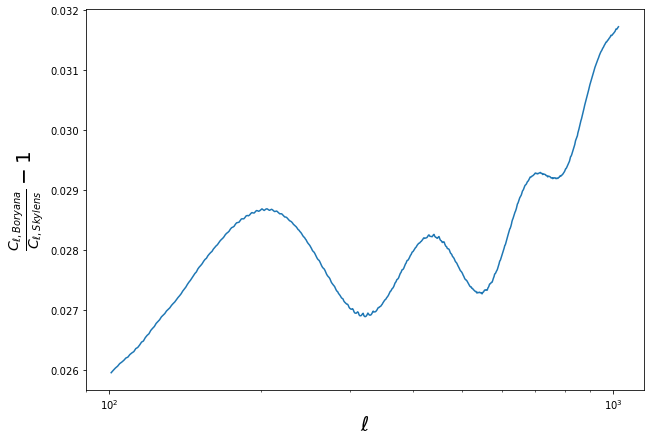

In [24]:
plt.figure(figsize=fsize)
plt.semilogx(results['kappa0'].l[ell > ell_min], 
             (cls_kk_boryana[results['kappa0'].l]/cl0G['cl'][corr_kk][bi].compute())[ell > ell_min] -1)
plt.xlabel(r"$\ell$", fontsize = fs)
plt.ylabel(r"$\frac{C_{\ell, Boryana}}{C_{\ell, Skylens}} - 1$", fontsize = fs)

**Observeration:** for $100 < \ell < 1024$, agreement between Skylens and Boryana's hacked `PyCCL` is around $\sim 1 \%$. 

### Compare with AbacusSummit sims 

Read in and process maps

In [25]:
#cmb 
kappa = hp.read_map("/mnt/store1/tkarim/kappa_ring_2048.fits")
mask = np.load("/mnt/store1/boryanah/AbacusSummit_base_c000_ph006/light_cones/mask_edges_ring_2048.npy")

#elg
elg = np.load("/mnt/gosling1/boryanah/light_cone_catalog/AbacusSummit_base_c000_ph006/products/gal_count_model_9_ring.npy")
elg_dgrade = hp.ud_grade(elg, nside_out=2048, power=-2) #convert elg map from 4096 to 2048
elg_dgrade = elg_dgrade.astype(np.float64) #convert to float from int

#apply mask
#cmb lensing
kappa_masked = hp.ma(kappa)
kappa_masked.mask = np.logical_not(mask)

#elg
elg_masked = hp.ma(elg_dgrade)
elg_masked.mask = np.logical_not(mask)

#convert elg map to delta map
elg_delta_masked = elg_masked/np.mean(elg_masked) - 1

/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = EXPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


12:28:22 DEBUG:locator: <healpy.projaxes.BoundaryLocator object at 0x7f2a4ff3fa30>
12:28:22 DEBUG:Using fixed locator on colorbar
12:28:22 DEBUG:Setting pcolormesh
12:28:23 DEBUG:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
12:28:23 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
12:28:23 DEBUG:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
12:28:23 DEBUG:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
12:28:23 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
12:28:23 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
12:28:23 DEBUG:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
12:28:23 DEBUG:findfont: score(<

12:28:23 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Bold.ttf) normal normal 700 condensed>) = 10.535
12:28:23 DEBUG:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-BoldItalic.ttf) italic normal 700 condensed>) = 11.535
12:28:23 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed.ttf) normal normal 400 condensed>) = 0.25
12:28:23 DEBUG:findfont: score(<Font 'Lato' (Lato-HeavyItalic.ttf) italic normal heavy normal>) = 11.43
12:28:23 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 0.24
12:28:23 DEBUG:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
12:28:23 DEBUG:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999
12:28:23 DEBUG:findfont: score(<Font 'Lato' (Lato-Regular.ttf) normal normal regular normal>) = 10.05
12:28:23 DEBUG:findfont: Matching sans\-serif:style=normal:variant=n

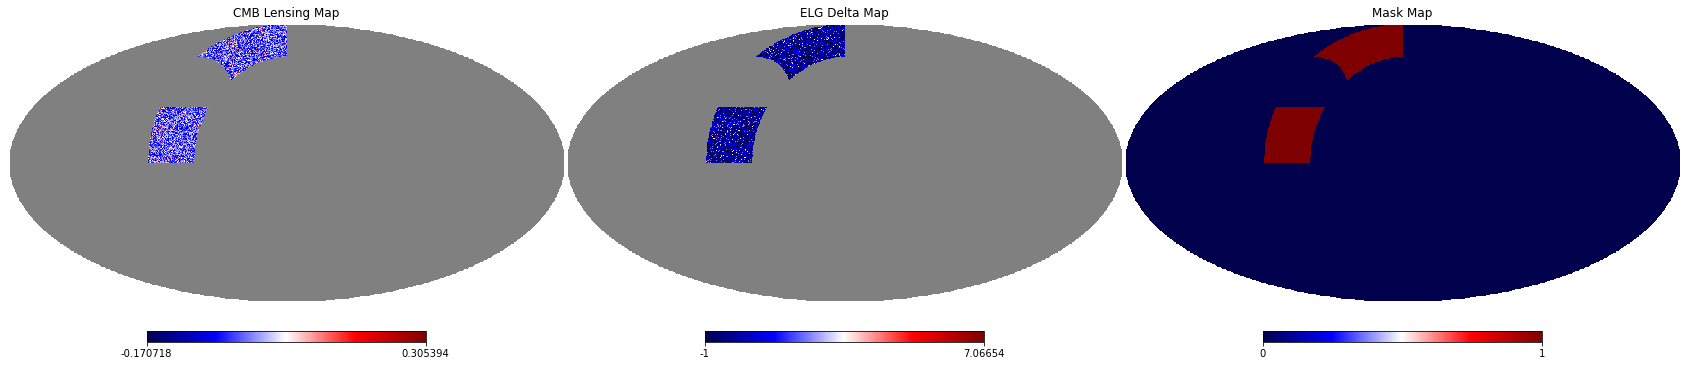

In [26]:
fg, ax = plt.subplots(ncols=3, figsize=(30, 10))
fg.subplots_adjust(wspace=0.0)

plt.sca(ax[0])
hp.mollview(kappa_masked, title = "CMB Lensing Map", hold = True, cmap = 'seismic')

plt.sca(ax[1])
hp.mollview(elg_delta_masked, title = "ELG Delta Map", hold = True, cmap = 'seismic')

plt.sca(ax[2])
hp.mollview(mask, title = "Mask Map", hold = True, cmap = 'seismic')

Calculate pseudo-$C_{\ell}$s

In [27]:
#auto spectra
clkk = hp.anafast(kappa_masked, lmax = lmax_cl - 1, pol = False)
clgg = hp.anafast(elg_delta_masked, lmax = lmax_cl - 1, pol = False)

#cross spectra
clkg = hp.anafast(kappa_masked, elg_delta_masked, lmax = lmax_cl - 1, pol = False)

<ipython-input-28-1ceff8f65ea3>:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogx(ell[flag_good_ell], ((clkk/fsky)/cls_kk_boryana)[flag_good_ell])


12:28:34 DEBUG:vmin 90.00299679254812 vmax 1136.773259181866
12:28:34 DEBUG:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:28:34 DEBUG:vmin 90.00299679254812 vmax 1136.773259181866
12:28:34 DEBUG:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:28:34 DEBUG:vmin 90.00299679254812 vmax 1136.773259181866
12:28:34 DEBUG:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:28:34 DEBUG:vmin 90.00299679254812 vmax 1136.773259181866
12:28:34 DEBUG:ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
12:28:34 DEBUG:vmin 90.00299679254812 vmax 1136.773259181866
12:2

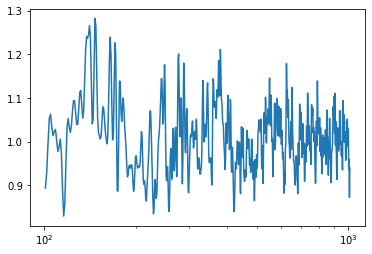

In [28]:
flag_good_ell = (ell > lmin_cl_Bins) & (ell < lmax_cl_Bins)
plt.semilogx(ell[flag_good_ell], ((clkk/fsky)/cls_kk_boryana)[flag_good_ell])

In [29]:
np.mean(((clkk/fsky)/cls_kk_boryana)[flag_good_ell])

<ipython-input-29-45ea5ec22c04>:1: RuntimeWarning: divide by zero encountered in true_divide
  np.mean(((clkk/fsky)/cls_kk_boryana)[flag_good_ell])


1.0074404658010756

/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


12:28:34 DEBUG:vmin 90.00299679254812 vmax 1136.773259181866
12:28:34 DEBUG:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:28:34 DEBUG:vmin 90.00299679254812 vmax 1136.773259181866
12:28:34 DEBUG:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:28:34 DEBUG:vmin 90.00299679254812 vmax 1136.773259181866
12:28:34 DEBUG:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:28:34 DEBUG:vmin 90.00299679254812 vmax 1136.773259181866
12:28:34 DEBUG:ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
12:28:34 DEBUG:vmin 90.00299679254812 vmax 1136.773259181866
12:2

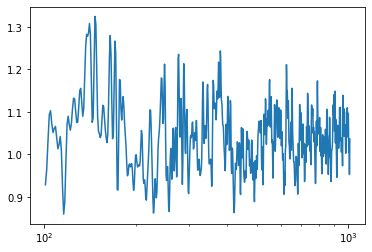

In [30]:
plt.semilogx(ell[flag_good_ell], (clkk/cl0G['pseudo_cl'][corr_kk][bi].compute())[flag_good_ell])

In [31]:
np.mean((clkk/cl0G['pseudo_cl'][corr_kk][bi].compute())[flag_good_ell])

/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


1.0391054688932295

In [32]:
(1/(cosmo_params['Om']/(cosmo_params['Omb'] + cosmo_params['Omd'])))**2

0.99101111651831

In [33]:
np.mean(((clkk * ((cosmo_params['Omb'] + cosmo_params['Omd'])/cosmo_params['Om'])**2)/cl0G['pseudo_cl'][corr_kk][bi].compute())[flag_good_ell])

1.0297650709081616

In [34]:
omega_nu = 0.0006442
omega_b = 0.02237
omega_cdm = 0.12
omega_m = omega_nu+omega_b+omega_cdm
h = 0.6736
Omega_m = omega_m/h**2
Omega_cb = (omega_b+omega_cdm)/h**2
factor = Omega_cb/Omega_m
print(factor)
print(factor**2)

0.9954955521899224
0.9910113944299185


Visualize all values

In [35]:
#Calculate shot noise
nbar = np.mean(elg_masked)/hp.nside2pixarea(nside=2*NSIDE) #need to do this in steradian
N_gg = 1/nbar * np.ones_like(ell) #galaxy shot noise

In [36]:
import sys
sys.path.insert(0,'/home/tkarim/desi-lensing-cc/scripts/') #path to scripts
from utils import bin_mat

In [37]:
ELL, CLkk = bin_mat(ell, clkk, np.arange(ell_min, ell_max, 100))
_, CLgg = bin_mat(ell, clgg, np.arange(ell_min, ell_max, 100))
_, CLkg = bin_mat(ell, clkg, np.arange(ell_min, ell_max, 100))
_, NLgg = bin_mat(ell, N_gg, np.arange(ell_min, ell_max, 100))

/home/tkarim/desi-lensing-cc/scripts/utils.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)
/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)
12:09:25 DEBUG:vmin 1.6087577586374816e-10 vmax 1.0623780876533692e-07
12:09:25 DEBUG:ticklocs array([1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05])
12:09:25 DEBUG:vmin 1.6087577586374816e-10 vmax 1.0623780876533692e-07
12:09:25 DEBUG:ticklocs array([1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05])
12:09:25 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
12:09:25 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:09:25 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
12:09:25 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])


(array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]),
 <a list of 5 Text major ticklabel objects>)

12:09:25 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
12:09:25 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:09:25 DEBUG:vmin 1.6087577586374816e-10 vmax 1.0623780876533692e-07
12:09:25 DEBUG:ticklocs array([1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05])
12:09:25 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
12:09:25 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:09:25 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
12:09:25 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:09:25 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
12:09:25 DEBUG:ticklocs array([2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.

12:09:26 DEBUG:vmin 1.6087577586374816e-10 vmax 1.0623780876533692e-07
12:09:26 DEBUG:ticklocs array([1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05])
12:09:26 DEBUG:vmin 1.6087577586374816e-10 vmax 1.0623780876533692e-07
12:09:26 DEBUG:ticklocs array([1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05])
12:09:26 DEBUG:vmin 1.6087577586374816e-10 vmax 1.0623780876533692e-07
12:09:26 DEBUG:ticklocs array([2.e-11, 3.e-11, 4.e-11, 5.e-11, 6.e-11, 7.e-11, 8.e-11, 9.e-11,
       2.e-10, 3.e-10, 4.e-10, 5.e-10, 6.e-10, 7.e-10, 8.e-10, 9.e-10,
       2.e-09, 3.e-09, 4.e-09, 5.e-09, 6.e-09, 7.e-09, 8.e-09, 9.e-09,
       2.e-08, 3.e-08, 4.e-08, 5.e-08, 6.e-08, 7.e-08, 8.e-08, 9.e-08,
       2.e-07, 3.e-07, 4.e-07, 5.e-07, 6.e-07, 7.e-07, 8.e-07, 9.e-07,
       2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05])
12:09:26 DEBUG:vmin 1.6087577586374816e-10 vmax 1.0623780876533692e-07
12:09:26 DEBUG:tic

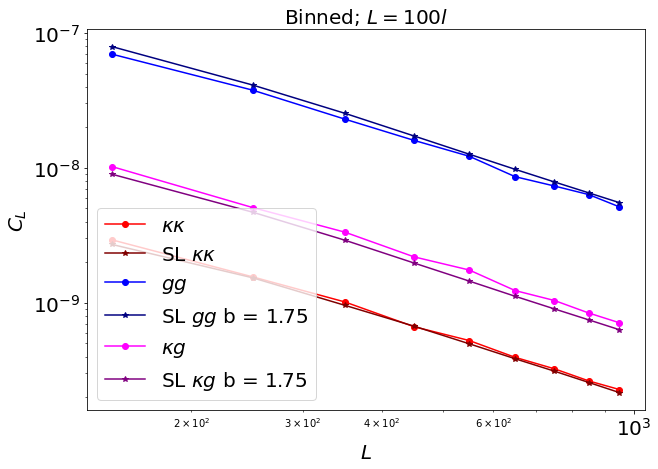

In [38]:
plt.figure(figsize = fsize)

#kk
plt.loglog(ELL, CLkk, label = r'$\kappa \kappa$', c = "r", marker = "o")
plt.loglog(lb[lb > lmin_cl_Bins], cl0G['pseudo_cl_b'][corr_kk][bi].compute()[lb > lmin_cl_Bins],
          label = r'SL $\kappa \kappa$', c = 'maroon', marker = '*')

#gg
plt.loglog(ELL, CLgg - NLgg*np.mean(mask), label = r'$gg$', c = "b", marker = "o")
plt.loglog(lb[lb > lmin_cl_Bins], cl0G['pseudo_cl_b'][corr_gg][bi].compute()[lb > lmin_cl_Bins],
          label = f'SL $gg$ b = {bg1}', c = 'navy', marker = "*")

#kg
plt.loglog(ELL, CLkg, label = r'$\kappa g$', c = "fuchsia", marker = "o")
plt.loglog(lb[lb > lmin_cl_Bins], cl0G['pseudo_cl_b'][corr_gk][bi].compute()[lb > lmin_cl_Bins],
          label = f'SL $\kappa g$ b = {bg1}', c = 'purple', marker = "*")

plt.legend(loc = 'best', fontsize = fs)
plt.xlabel(r"$L$", fontsize = fs)
plt.ylabel(r"$C_{L}$", fontsize = fs)
plt.title("Binned; $L = 100 l$", fontsize = fs)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)

/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


Text(0, 0.5, '$\\frac{C^{Abacus}_{L}}{C^{SkyLens}_{L}} - 1$')

12:09:31 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
12:09:31 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:09:31 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
12:09:31 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:09:31 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
12:09:31 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:09:31 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
12:09:31 DEBUG:ticklocs array([2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
12:09:31 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
12:09:31 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
12:09:31 DEBUG:vm

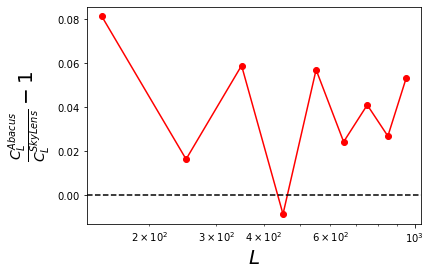

In [39]:
plt.semilogx(ELL, CLkk/(cl0G['pseudo_cl_b'][corr_kk][bi].compute())[lb > lmin_cl_Bins] - 1,
            label = r'$\kappa \kappa_{\rm Abs}$', c = "r", marker = "o")
plt.axhline(0, c = 'k', ls = '--')

plt.xlabel(r"$L$", fontsize = fs)
plt.ylabel(r"$\frac{C^{Abacus}_{L}}{C^{SkyLens}_{L}} - 1$", fontsize = fs)

In [40]:
np.mean(CLkk/(cl0G['pseudo_cl_b'][corr_kk][bi].compute())[lb > lmin_cl_Bins] - 1)

/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


0.03898561753832687

### Check covariance from Skylens

10:38:46 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc0a1933820>
10:38:46 DEBUG:Using auto colorbar locator on colorbar
10:38:46 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc0a1933820>
10:38:46 DEBUG:Setting pcolormesh
10:38:46 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc0a1881e80>
10:38:46 DEBUG:Using auto colorbar locator on colorbar
10:38:46 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc0a1881e80>
10:38:46 DEBUG:Setting pcolormesh
10:38:47 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc0a17f2520>
10:38:47 DEBUG:Using auto colorbar locator on colorbar
10:38:47 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc0a17f2520>
10:38:47 DEBUG:Setting pcolormesh
10:38:47 DEBUG:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc0a181ca90>
10:38:47 DEBUG:Using auto colorbar locator on colorbar
10:38:47 DEBUG:locator: <matplotli

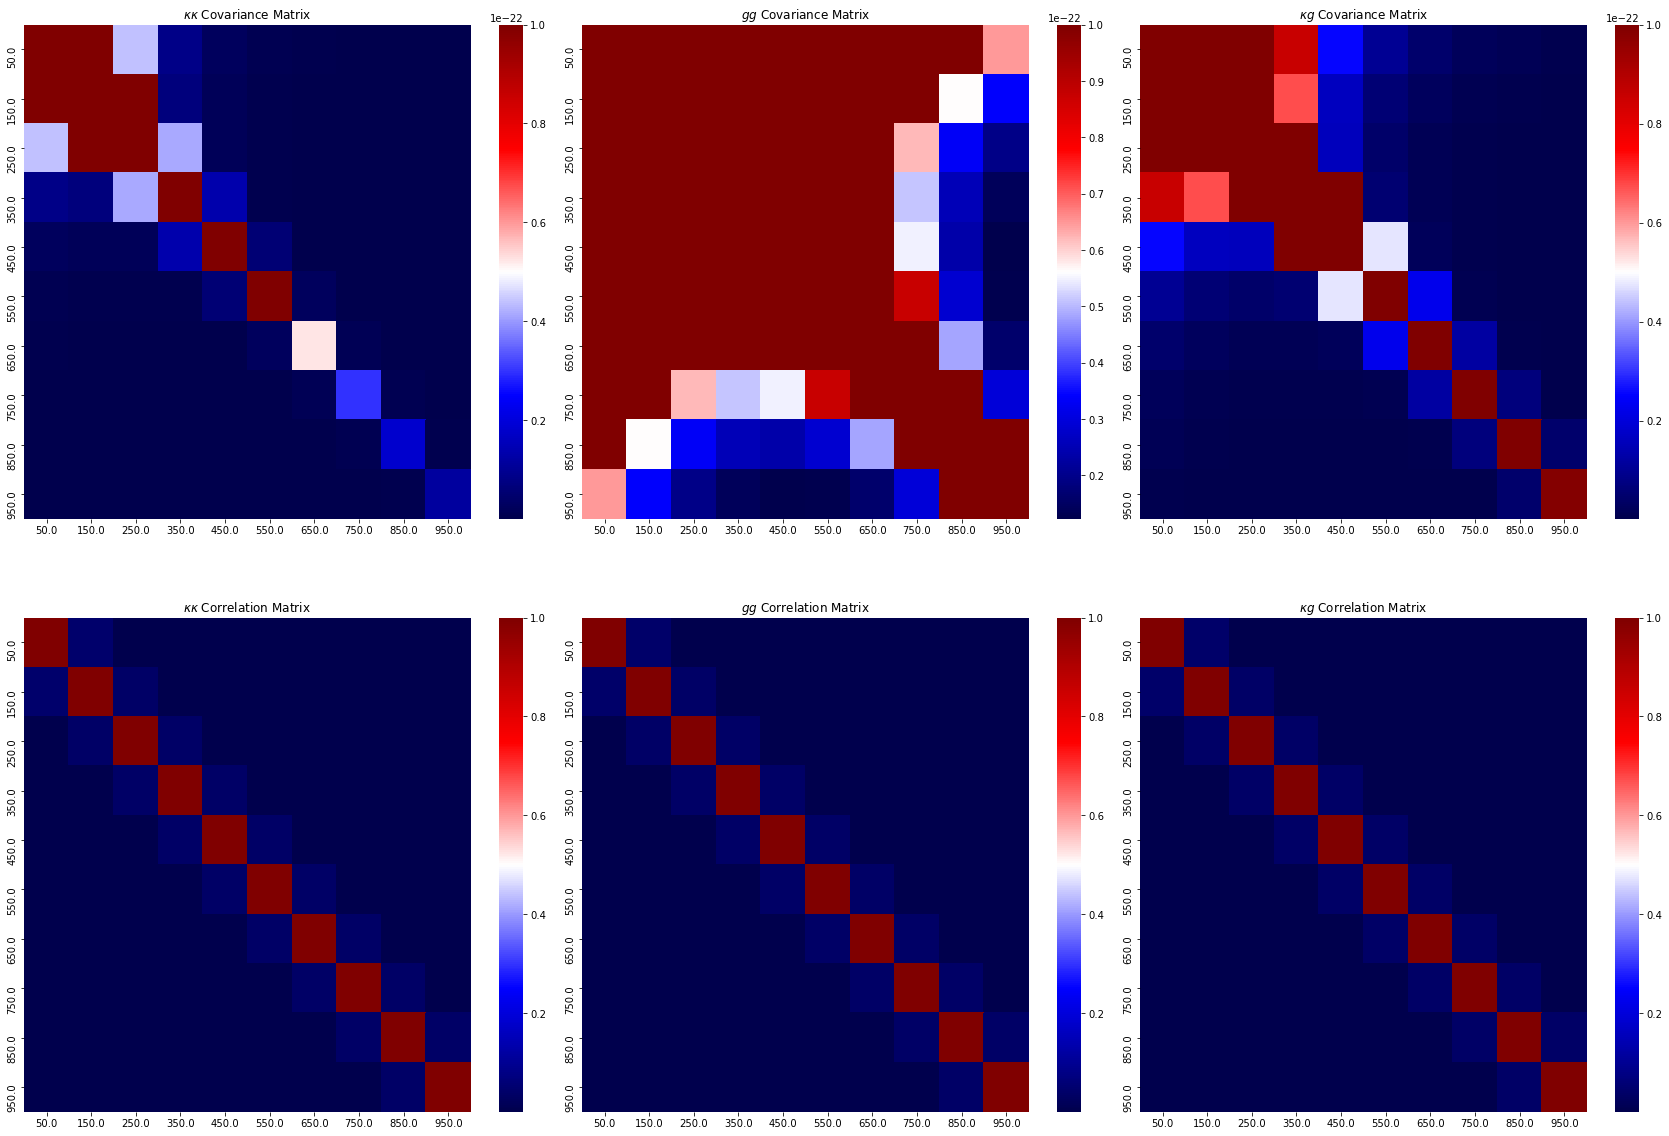

In [40]:
#covariance matrix
cov_kk = cl0G['cov'][corr_kk+corr_kk][bi+bi].compute()['final_b']
err_kk = np.sqrt(np.diag(cov_kk))
cov_gg = cl0G['cov'][corr_gg+corr_gg][bi+bi].compute()['final_b']
err_gg = np.sqrt(np.diag(cov_gg))
cov_kg = cl0G['cov'][corr_kk+corr_gg][bi+bi].compute()['final_b']
err_kg = np.sqrt(np.diag(cov_kg))

#correlation matrix
corrmat_kk = cov_kk/np.outer(err_kk, err_kk)
corrmat_gg = cov_gg/np.outer(err_gg, err_gg)
corrmat_kg = cov_kg/np.outer(err_kg, err_kg)

fg, ax = plt.subplots(ncols=3, nrows = 2, figsize=(30, 20))
fg.subplots_adjust(wspace=0.0)

plt.sca(ax[0, 0])
plt.title(r"$\kappa \kappa$ Covariance Matrix")
sns.heatmap(cov_kk, vmax = 1e-22, xticklabels=lb, yticklabels=lb, cmap = 'seismic')

plt.sca(ax[0, 1])
plt.title(r"$gg$ Covariance Matrix")
sns.heatmap(cov_gg, vmax = 1e-22, xticklabels=lb, yticklabels=lb, cmap = 'seismic')

plt.sca(ax[0, 2])
plt.title(r"$\kappa g$ Covariance Matrix")
sns.heatmap(cov_kg, vmax = 1e-22, xticklabels=lb, yticklabels=lb, cmap = 'seismic')

plt.sca(ax[1, 0])
plt.title(r"$\kappa \kappa$ Correlation Matrix")
sns.heatmap(corrmat_kk, xticklabels=lb, yticklabels=lb, cmap = 'seismic')

plt.sca(ax[1, 1])
plt.title(r"$gg$ Correlation Matrix")
sns.heatmap(corrmat_gg, xticklabels=lb, yticklabels=lb, cmap = 'seismic')

plt.sca(ax[1, 2])
plt.title(r"$\kappa g$ Correlation Matrix")
sns.heatmap(corrmat_kg, xticklabels=lb, yticklabels=lb, cmap = 'seismic')

10:38:48 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
10:38:48 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
10:38:48 DEBUG:vmin 1.6164997403487743e-10 vmax 1.0972008484860974e-07
10:38:48 DEBUG:ticklocs array([1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05])
10:38:48 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
10:38:48 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
10:38:48 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
10:38:48 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
10:38:48 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
10:38:48 DEBUG:ticklocs array([2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.

10:38:48 DEBUG:vmin 1.6164997403487743e-10 vmax 1.0972008484860974e-07
10:38:48 DEBUG:ticklocs array([1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05])
10:38:48 DEBUG:vmin 1.6164997403487743e-10 vmax 1.0972008484860974e-07
10:38:48 DEBUG:ticklocs array([1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05])
10:38:48 DEBUG:vmin 1.6164997403487743e-10 vmax 1.0972008484860974e-07
10:38:48 DEBUG:ticklocs array([2.e-11, 3.e-11, 4.e-11, 5.e-11, 6.e-11, 7.e-11, 8.e-11, 9.e-11,
       2.e-10, 3.e-10, 4.e-10, 5.e-10, 6.e-10, 7.e-10, 8.e-10, 9.e-10,
       2.e-09, 3.e-09, 4.e-09, 5.e-09, 6.e-09, 7.e-09, 8.e-09, 9.e-09,
       2.e-08, 3.e-08, 4.e-08, 5.e-08, 6.e-08, 7.e-08, 8.e-08, 9.e-08,
       2.e-07, 3.e-07, 4.e-07, 5.e-07, 6.e-07, 7.e-07, 8.e-07, 9.e-07,
       2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05])
10:38:48 DEBUG:vmin 1.6164997403487743e-10 vmax 1.0972008484860974e-07
10:38:48 DEBUG:tic

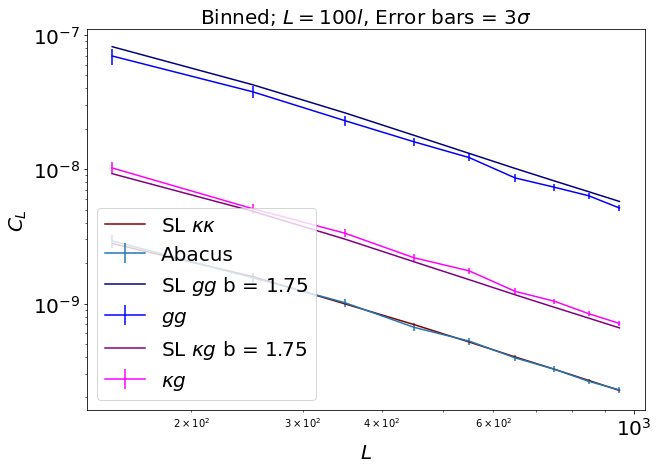

In [41]:
plt.figure(figsize = fsize)

#kk
plt.errorbar(lb[lb > lmin_cl_Bins], cl0G['pseudo_cl_b'][corr_kk][bi].compute()[lb > lmin_cl_Bins],
          label = r'SL $\kappa \kappa$', c = 'maroon')
plt.errorbar(ELL, CLkk, yerr = 3*err_kk[lb > ell_min], label = 'Abacus')

#gg
plt.errorbar(lb[lb > lmin_cl_Bins], cl0G['pseudo_cl_b'][corr_gg][bi].compute()[lb > lmin_cl_Bins],
          label = r'SL $gg$ b = 1.75', c = 'navy')
plt.errorbar(ELL, CLgg - NLgg*np.mean(mask), yerr = 3*err_gg[lb > lmin_cl_Bins], label = r'$gg$', c = "b")

#kg
plt.errorbar(lb[lb > lmin_cl_Bins], cl0G['pseudo_cl_b'][corr_gk][bi].compute()[lb > lmin_cl_Bins],
          label = r'SL $\kappa g$ b = 1.75', c = 'purple')
plt.errorbar(ELL, CLkg, yerr = 3*err_kg[lb > ell_min], label = r'$\kappa g$', c = "fuchsia")

plt.legend(loc = 'best', fontsize = fs)
plt.xlabel(r"$L$", fontsize = fs)
plt.ylabel(r"$C_{L}$", fontsize = fs)
plt.title("Binned; $L = 100 l$, Error bars = $3\sigma$", fontsize = fs)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)
plt.xscale("log")
plt.yscale("log")

Text(0, 0.5, '$\\frac{C^{\\kappa \\kappa}_{\\ell, Abacus}}{C^{\\kappa \\kappa}_{\\ell, Skylens}}$')

10:38:49 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
10:38:49 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
10:38:49 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
10:38:49 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
10:38:49 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
10:38:49 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
10:38:49 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
10:38:49 DEBUG:ticklocs array([2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
10:38:49 DEBUG:vmin 136.77591907931168 vmax 1041.8500636604688
10:38:49 DEBUG:ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
10:38:49 DEBUG:vm

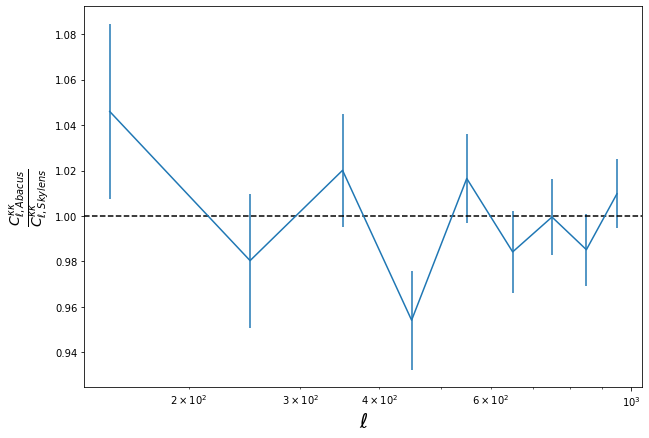

In [42]:
plt.figure(figsize = fsize)
plt.errorbar(lb[lb > ell_min], CLkk/cl0G['pseudo_cl_b'][corr_kk][bi].compute()[lb > ell_min],
             yerr = np.sqrt(np.diag(cl0G['cov'][('kappa', 'kappa', 'kappa', 'kappa')][(0, 0, 0, 0)].compute()['final_b']))[lb > ell_min]/cl0G['pseudo_cl_b'][corr_kk][bi].compute()[lb > ell_min],
            )
plt.axhline(1, c = 'k', ls = '--')
plt.xscale("log")
plt.xlabel(r"$\ell$", fontsize = fs)
plt.ylabel(r"$\frac{C^{\kappa \kappa}_{\ell, Abacus}}{C^{\kappa \kappa}_{\ell, Skylens}}$", fontsize = fs)

In [43]:
def chi2(data, model, var):
    return np.sum((data - model)**2/var)

In [44]:
chi2(CLkk, cl0G['pseudo_cl_b'][corr_kk][bi].compute()[lb > ell_min], 
     (err_kk**2)[lb > ell_min])/9

1.0793552881753408

## Test for window effects

In [117]:
cls_cmb_th = cl0G['cl'][corr_ll][bi].compute()
cls_elg_th = cl0G['cl'][corr_gg][bi].compute()
cls_crs_th = cl0G['cl'][corr_gl][bi].compute()

In [131]:
#generate synthetic map using theory Cls
m_k, m_g = hp.synfast((cls_cmb_th, cls_crs_th, cls_elg_th), 2*NSIDE, pol=False, verbose=False)

06:57:40 DEBUG:locator: <healpy.projaxes.BoundaryLocator object at 0x7f2f4438b5e0>
06:57:40 DEBUG:Using fixed locator on colorbar
06:57:40 DEBUG:Setting pcolormesh


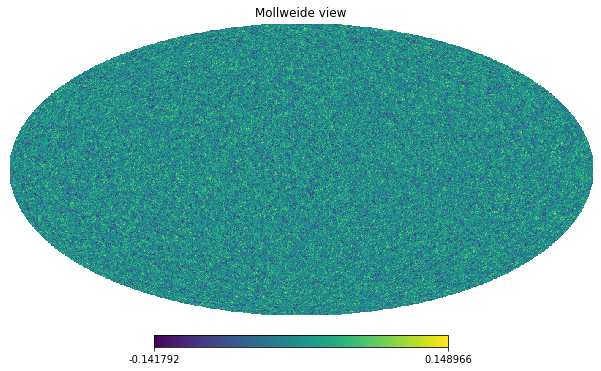

In [132]:
hp.mollview(m_k)

06:57:41 DEBUG:locator: <healpy.projaxes.BoundaryLocator object at 0x7f2f54b1b490>
06:57:41 DEBUG:Using fixed locator on colorbar
06:57:41 DEBUG:Setting pcolormesh


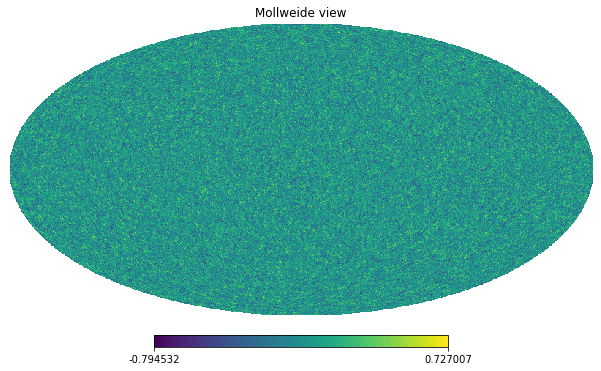

In [133]:
hp.mollview(m_g)

06:57:42 DEBUG:locator: <healpy.projaxes.BoundaryLocator object at 0x7f2f4448f5b0>
06:57:42 DEBUG:Using fixed locator on colorbar
06:57:42 DEBUG:Setting pcolormesh


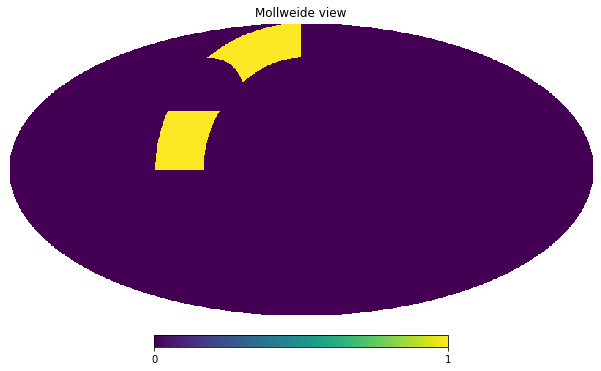

In [134]:
hp.mollview(mask)

In [135]:
#cmb lensing
kappa_masked = hp.ma(m_k)
kappa_masked.mask = np.logical_not(mask)

#elg
elg_masked = hp.ma(m_g)
elg_masked.mask = np.logical_not(mask)

06:57:47 DEBUG:locator: <healpy.projaxes.BoundaryLocator object at 0x7f2f44704490>
06:57:47 DEBUG:Using fixed locator on colorbar
06:57:47 DEBUG:Setting pcolormesh


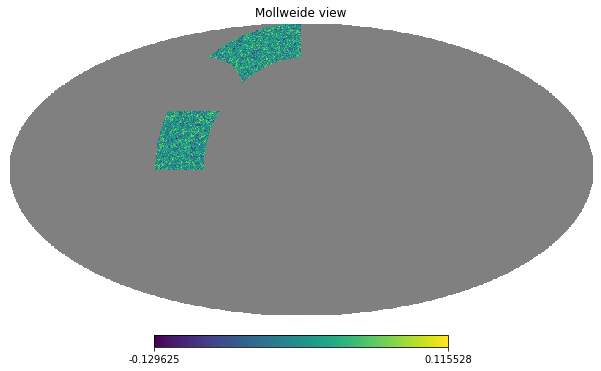

In [136]:
hp.mollview(kappa_masked)

06:57:47 DEBUG:locator: <healpy.projaxes.BoundaryLocator object at 0x7f2f4c352af0>
06:57:47 DEBUG:Using fixed locator on colorbar
06:57:47 DEBUG:Setting pcolormesh


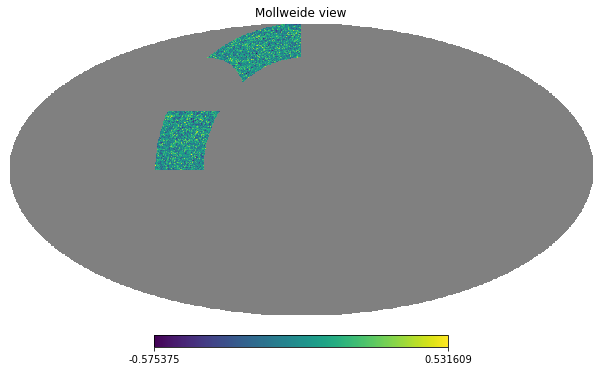

In [137]:
hp.mollview(elg_masked)

In [138]:
#calculate Cls

#auto spectra
clkk_syn = hp.anafast(kappa_masked, lmax = lmax_cl - 1, pol = False)
clgg_syn = hp.anafast(elg_masked, lmax = lmax_cl - 1, pol = False)

#cross spectra
clkg_syn = hp.anafast(kappa_masked, elg_masked, lmax = lmax_cl - 1, pol = False)

/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


06:59:12 DEBUG:vmin 0.7071413255983454 vmax 1446.6697998938064
06:59:12 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
06:59:12 DEBUG:vmin 9.141940130463519e-11 vmax 9.338398063707616e-09
06:59:12 DEBUG:ticklocs array([1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07])
06:59:12 DEBUG:vmin 0.7071413255983454 vmax 1446.6697998938064
06:59:12 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
06:59:12 DEBUG:vmin 0.7071413255983454 vmax 1446.6697998938064
06:59:12 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
06:59:12 DEBUG:vmin 0.7071413255983454 vmax 1446.6697998938064
06:59:12 DEBUG:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
   

06:59:13 DEBUG:vmin 0.7071413255983454 vmax 1446.6697998938064
06:59:13 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
06:59:13 DEBUG:vmin 0.7071413255983454 vmax 1446.6697998938064
06:59:13 DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
06:59:13 DEBUG:vmin 0.7071413255983454 vmax 1446.6697998938064
06:59:13 DEBUG:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
06:59:13 DEBUG:vmin 9.1419

06:59:13 DEBUG:ticklocs array([1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07])
06:59:13 DEBUG:vmin 9.141940130463519e-11 vmax 9.338398063707616e-09
06:59:13 DEBUG:ticklocs array([1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07])
06:59:13 DEBUG:vmin 9.141940130463519e-11 vmax 9.338398063707616e-09
06:59:13 DEBUG:ticklocs array([2.e-12, 3.e-12, 4.e-12, 5.e-12, 6.e-12, 7.e-12, 8.e-12, 9.e-12,
       2.e-11, 3.e-11, 4.e-11, 5.e-11, 6.e-11, 7.e-11, 8.e-11, 9.e-11,
       2.e-10, 3.e-10, 4.e-10, 5.e-10, 6.e-10, 7.e-10, 8.e-10, 9.e-10,
       2.e-09, 3.e-09, 4.e-09, 5.e-09, 6.e-09, 7.e-09, 8.e-09, 9.e-09,
       2.e-08, 3.e-08, 4.e-08, 5.e-08, 6.e-08, 7.e-08, 8.e-08, 9.e-08,
       2.e-07, 3.e-07, 4.e-07, 5.e-07, 6.e-07, 7.e-07, 8.e-07, 9.e-07])
06:59:13 DEBUG:vmin 9.141940130463519e-11 vmax 9.338398063707616e-09
06:59:13 DEBUG:ticklocs array([1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07])
06:59:13 DEBUG:vmin 9.141940130463519e-11 vmax 9.338398063707616e-09
06:59:13 DEBUG:ticklocs array([1.

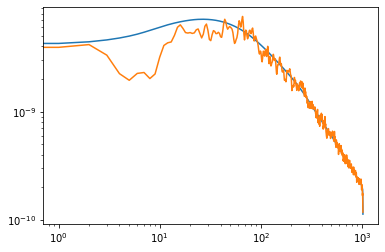

In [143]:
#plt.loglog(cls_cmb_th * f_sky, label = 'Theory')
plt.loglog(np.arange(lmax_cl), cl0G['pseudo_cl'][corr_ll][bi].compute())
plt.loglog(np.arange(lmax_cl),clkk_syn, label = 'Gaussian Sim')

07:00:23 DEBUG:vmin 89.95880149740823 vmax 1148.5590990557696
07:00:23 DEBUG:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
07:00:23 DEBUG:vmin 89.95880149740823 vmax 1148.5590990557696
07:00:23 DEBUG:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
07:00:23 DEBUG:vmin 89.95880149740823 vmax 1148.5590990557696
07:00:23 DEBUG:ticklocs array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])
07:00:23 DEBUG:vmin 89.95880149740823 vmax 1148.5590990557696
07:00:23 DEBUG:ticklocs array([2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05])
07:00:23 DEBUG:vmin 89.95880149740823 vmax 1148.5590990557696

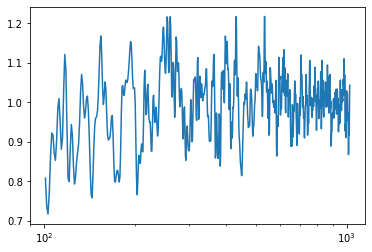

In [149]:
plt.semilogx(ell[ell > ell_min], (clkk_syn/cl0G['pseudo_cl'][corr_ll][bi].compute())[ell > ell_min])

In [150]:
np.mean((clkk_syn/cl0G['pseudo_cl'][corr_ll][bi].compute())[ell > ell_min])

/home/tkarim/SkyLens/skylens/tracer_utils.py:351: RuntimeWarning: invalid value encountered in true_divide
  kernel['gkernel_int']/=np.sum(pz_zl*dzl)


0.9970267211959595